# Image Classification of Elephants and Zebras using Neural Networks

### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from skimage import io,color
from skimage.transform import resize
from skimage.util import crop

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

from sklearn.metrics import confusion_matrix

## Data Analysis
The data will be loaded into three sets upon which our analysis will take place, namely the training, validation and test sets. Each of the models will be fit on the training data and their respective accuracies will calculated by how close the model's predictions come to the validation set. The test set is reserved for comparing different models with each other to ultimately choose the best model.

A sample plot of the images will be created so that we may get a sense of the input data for this image classification problem.

### Display a sample of the images

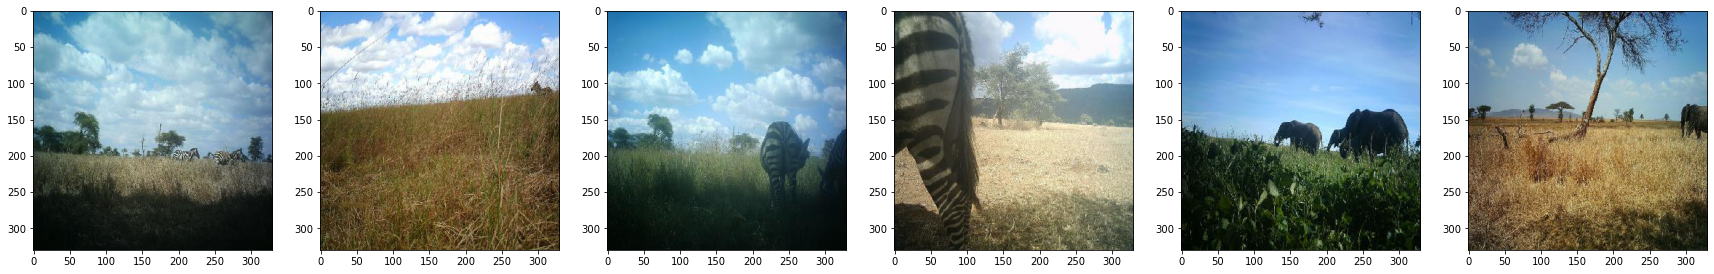

In [4]:
num_plots = 6

fig, ax = plt.subplots(1,num_plots, figsize = (30,50))

directory = r'data/Valid'
np.random.seed(2022)
elephant_or_zebra = ['elephant_valid','zebra_valid']

for i in range(num_plots):
    rand_animal =np.random.randint(2)
    folder = os.path.join(directory,elephant_or_zebra[rand_animal])
    rand_image = np.random.randint(1000)
    ax[i].imshow(io.imread(os.path.join(folder,os.listdir(folder)[rand_image])))
    
plt.show()

### Creation of Training, Validation and Testing Sets

In [5]:
category_train_dir_labels = ['Elephant_train', 'Zebra_train']
category_valid_dir_labels = ['Elephant_valid', 'Zebra_valid']
category_test_dir_labels = ['Elephant_test', 'Zebra_test']

train_directory =r'data/train/'
valid_directory =r'data/valid/'
test_directory =r'data/test/'

labels = ['elephant','zebra']

# Training Set

train_data = []

train_elephant = 0
for category_label in category_train_dir_labels:
    folder = os.path.join(train_directory,category_label)
    label=category_train_dir_labels.index(category_label)
    
    for i, img in enumerate(os.listdir(folder)):
        img_path=os.path.join(folder,img)
        img_arr = color.rgb2gray(resize(io.imread(img_path), (100, 100)))
        train_data.append([img_arr,label])
        if label=='elephant':
            train_elephant += 1
        if i%5==0:
            img_arr = resize(crop(color.rgb2gray(np.fliplr(io.imread(img_path))),50),(100, 100))
            train_data.append([img_arr, label])
            if label=='elephant':
                train_elephant += 1

# Validation Set

valid_data = []
for category_label in category_valid_dir_labels:
    folder = os.path.join(valid_directory,category_label)
    label=category_valid_dir_labels.index(category_label)
    
    for img in os.listdir(folder):
        
        img_path=os.path.join(folder,img)
        img_arr = color.rgb2gray(resize(io.imread(img_path),(100,100)))
        valid_data.append([img_arr,label])
        
# Testing Set

test_data = []
for category_label in category_test_dir_labels:
    folder = os.path.join(test_directory,category_label)
    label=category_test_dir_labels.index(category_label)
    
    for img in os.listdir(folder):
        img_path=os.path.join(folder,img)
        img_arr =color.rgb2gray(resize(io.imread(img_path),(100,100)))
        
        test_data.append([img_arr,label])

Note: One of the image files was corrupt and has been excluded from the data.

There were 13999 images with unique identifiers. Each image is 330x330 pixels and are in full colour.
The images were split as follows:

    Elephants:
        Training:     0 - 5000
        Validation:   5000 - 5999
        Testing:      60000 - 6999
        
    Zebras:
        Training:    7000 - 11999
        Validation:   12000 - 12999
        Testing:      13000 - 13999

A sample of these images were plotted to get a sense of the dataset, specifically its dimensions and colour characteristics.

In [6]:
# barplot showing that the number of elephants vs zebras in each of the sets is equal, i.e. that the dataset is balances


From the above plot it is clear that the dataset is balanced, i.e. that in each of the sets of data (training, validation, testing) the counts in each category are approximately even. This is an indication that the accuracy metric will give valuable insight into how well the models perform and we will use it as the primary performance metric.

## Data Augmentation
The training data consists of 10000 images. We decided that this was just about sufficient, however, to augment the data, we will transform 2000 of the training samples using two methods. They will be flipped as well as cropped (and zoomed in on) to ensure that they are different enough from the given training data. This number was kept relatively low to avoid overfitting to the training data. For convenience these steps were completed as the images were read into the training data. 

## Data Preparation
The original data was 330x330 pixels. Considering that we intend to define neural networks to classify these images, it would be beneficial to resize the images. This is because each pixel increases the dimension of the input and layers with more nodes will be required to extract insightful information from the images. This not only increases the complexity of the model, it also increases the time required for computation. Thus, the images were resized to 100x100 pixels; this was done when reading in the images for convenience.

Furthermore, the original images were in full colour. Given that the likely distinctions between the elephants and zebras will be lie in the differing patterns (striped vs monochrome) we can convert the images to grayscale. A great benefit to doing this is that each sample image will have its dimension reduced, specifically (R, G, B) → (value). This was done when reading in the images for convenience.

In the dataset, the images are indexed so that the elephants are grouped separately from the zebras, however, for the models to be trained well, it will be of benefit to first shuffle (randomize the order of) the input images so that the models do not fit to all of one category first and give weight to patterns which are irrelevant to discrimitating between the categories, elephant and zebra.

At this point, the images are stored in a list and the Neural Network models require the data to be in arrays, so these will be converted to numpy arrays.

### Shuffle the Data Order

In [7]:
random.seed(2022)
random.shuffle(train_data)
random.shuffle(test_data)
random.shuffle(valid_data)

### Conversion to Arrays

In [8]:
X_train = []
y_train = []
for feature, label in train_data:
    X_train.append(feature)
    y_train.append(label)

X_valid = []
y_valid = []
for feature, label in valid_data:
    X_valid.append(feature)
    y_valid.append(label)

X_test = []
y_test = []
for feature, label in test_data:
    X_test.append(feature)
    y_test.append(label)

X_train = np.array(X_train).reshape(len(X_train), 100, 100, 1)
y_train = np.array(y_train).reshape(len(y_train), 1)

X_valid = np.array(X_valid).reshape(len(X_valid), 100, 100, 1)
y_valid = np.array(y_valid).reshape(len(y_valid), 1)

X_test = np.array(X_test).reshape(len(X_test), 100, 100, 1)
y_test = np.array(y_test).reshape(len(y_test), 1)

# Dimension Check
print(X_train.shape)

(11999, 100, 100, 1)


This dimension check was done to ensure that the correct number of images are in the training set and that they are the correct size. Since there 10000 images, one of which was corrupt, and we augmented the training data with a further 2000 transformed images, the number of images is correct. Also, the dimensions of each image is correct and we can proceed.

### Display Sample of Prepared Data

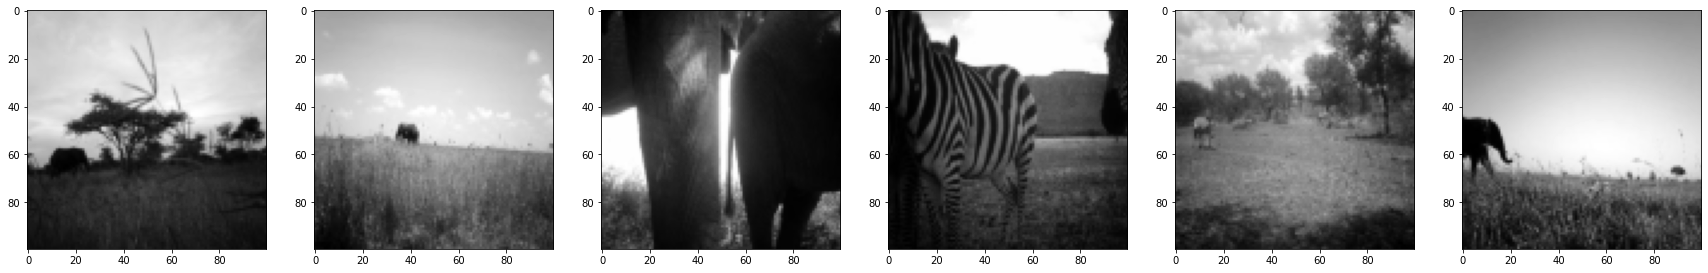

In [9]:
fig, ax = plt.subplots(1,num_plots, figsize = (30,30))

for i in range(num_plots):
    rand_image = np.random.randint(2000)
    ax[i].imshow(X_valid[rand_image],cmap=plt.cm.gray)
    
plt.show()

## Model Choice
The use of a Convoluted Neural Network (CNN) is the industry standard for image classification. Therefore, rather than using different types of Neural Networks, we intend to use multiple CNNs with layers in different configurations. The layers we are considering are:

    > Dense Layer (Dense): fully connected layer constructed using a linear operation that maps every input to the output (i.e. each input is considered in determining the output). 
    
    > Convolutional Layer (Conv2D): creates a mapping of the original image that looks for patterns such as edges by grouping inputs; this type of layer has fewer parameters than a Dense layer with the same number of nodes and thus adds less complexity to the model.
    
    > Pooling Layer (MaxPool2D): groups inputs in the same region and assigns one value to the group, thereby simplifying the input; this also serves to lessen the complexity of the model.
    
    > Flatten Layer (Flatten): converts the output of the Convolutional Layer to a form that is interpretable by the Dense Layer, thereby acting as a bridge between these two layers.
    
Multiple models of varying complexity and differing hyperparameters will be considered.

By adding and removing complexity as well as altering the hyperparameters, we aim to iteratively improve the accuracy of each subsequent model.

The process of adding layers in this way can be generalized and so a function will be written to create and compile the models.

From here on, configurations of these layers will be expressed by the first letters of the names of the layers in their appropriate order. D: Dense, C: Convolutional, P: Pooling, F: Flatten. The configuration CFD, for example, begins with a Convolutional Layer, which is followed by a Flatten Layer and ends with a Dense Layer.  

### Function for Creating and Compiling the Models

In [10]:
def createModel(number_of_layers, output_activation, opt='adam'):
    
    model = Sequential()
    for i in range(number_of_layers):
        model.add(Conv2D(32,(3,3),activation='relu',padding='same', input_shape = (100,100,1)))
        model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation=output_activation))
    model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    print('Model Summary:')
    print(model.summary())
    
    return model

#### Model 1
The first model that we are creating is a CNN with the configuration: CPFDD (as explained above). This model's complexity is moderate as there are about 5 million total parameters, as shown in the model summary below. The default - adam - optimizer and the softmax output activation will be used. The intention here is that this model will create a baseline for performance as well as complexity.

In [11]:
cnn1 = createModel(number_of_layers=1, output_activation='softmax')
history1 = cnn1.fit(X_train, y_train, epochs = 10,validation_data=(X_valid, y_valid), batch_size=64)


Model Summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5120064   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,120,449
Trainable params: 5,120,449
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.w

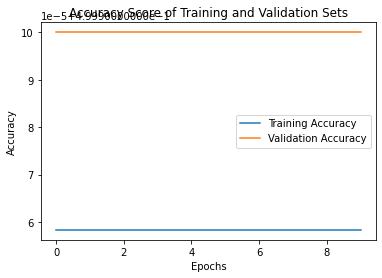

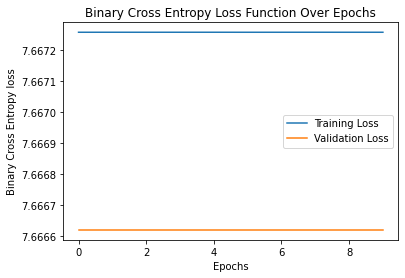

In [19]:
def plot_acc_vs_epochs(hist):
    plt.plot(hist.history['accuracy'], label = 'Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
    plt.title("Accuracy Score of Training and Validation Sets")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss_vs_epochs(hist):
    plt.plot(hist.history['loss'],label = 'Training Loss')
    plt.plot(hist.history['val_loss'], label = 'Validation Loss')
    plt.title("Binary Cross Entropy Loss Function Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy loss")
    plt.legend()
    plt.show()
        
plot_acc_vs_epochs(history1)
plot_loss_vs_epochs(history1)

In fitting this model, it can be seen that the softmax output activation caused the model to stagnate. This is because softmax is useful for classifcation problems where the number of categories exceeds two, that is, it is ill-suited to binary classfication. No further commentary will be made on the performance of this model as we do not believe this to be a valid model.

#### Model 2

For model 2, we will take heed of the results of the first model and change the output activation from softmax to sigmoid; all else will remain the same. Considering that each time we fit a model, the computation time is very large, we will continue to tune in this way, changing configurations and parameters as we go - a process of trial and improvement. The configuration here is again CPFDD.

In [17]:
cnn2 = createModel(number_of_layers=1, output_activation='sigmoid')
history2 = cnn2.fit(X_train, y_train, epochs = 10, validation_data=(X_valid, y_valid), batch_size=64)

Model Summary:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                5120064   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,120,449
Trainable params: 5,120,449
Non-trainable params: 0
_________________________________________________________________
None
Train on 11999 samples, validate on 2000 samples
Epoch 1/10
11999/11999 [=================

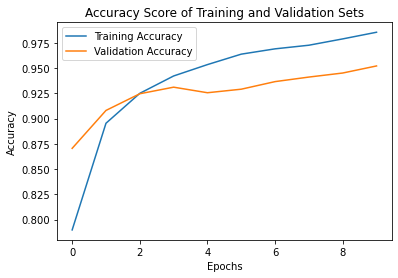

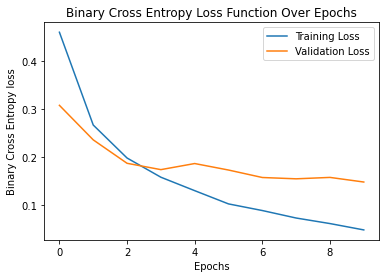

In [18]:
plot_acc_vs_epochs(history2)
plot_loss_vs_epochs(history2)

The results of this model are more promising than the first, highlighting that the sigmoid activation is better-suited to our problem. The accuracy of the model is above 90%. In the first graph, the general trend is that as the number of epochs increases, the accuracy increases, and in the second graph, the general trend is that the loss decreases as the number of epochs increases. Therefore, we feel confident keeping the number of epochs high. Overfitting was low as there was little difference between the accuracy scores of the training and validation sets. The binary cross entropy was appropriate  because this is a binary classification problem. We used the relu activation in the hidden layers of the model as this is the generally accepted activation function. We used the adam optimizer because it is adaptive.

#### Model 3

For this model, we aim to decrease the complexity of the model in the previous step. We will do this by adding more layers; this seems counter-intuitive, however, by adding another layer of both convolution and pooling to the start, we can decrease the total number of parameters in the model from over 5 million to about 1 million. The hyperparameters of the model will be kept the same. We hope to maintain the high level of accuracy attained in Model 2. The configuration will be of the form CPCPFDD.

In [21]:
cnn3 = createModel(number_of_layers=2, output_activation='sigmoid')
history3 = cnn3.fit(X_train, y_train, epochs = 10, validation_data=(X_valid, y_valid), batch_size=64)

Model Summary:
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1280064   
_________________________________________________________________
dense_8 (Dense)              (None, 1) 

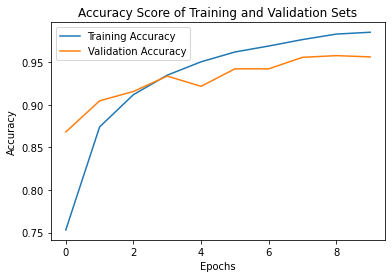

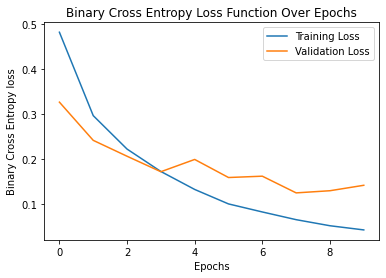

In [22]:
plot_acc_vs_epochs(history3)
plot_loss_vs_epochs(history3)

The accuracy results attained in Model 2 were replicated in Model 3, still exceeding 90%, while attaining a large reduction in complexity. The presence of overfitting was low as there was little difference between the accuracy scores of the training and validation sets. The hyperparameters that were previously justified were kept the same to determine the isolated effect of adding the additional hidden layers on model accuracy. In graph 1, the general trend is that as the number of epochs increases the accuracy increases, and in graph 2, the general trend is that as the number of epochs increases, the number loss decreases.

#### Model 4

With this model, we intend to determine the effect of changing the optimizer from the adaptive adam optimizer to the more flexible SGD optimizer. The SGD optimizer requires the specification of a learning rate. We will begin with an initial estimate of an appropriate learning rate and then based on how well it performs we will determine whether the required tuning of the learning rate hyperparameter is worth the any possible additional accuracy. The complexity of this Model will again be moderate as the number of parameters returns to about 5 million. The model configuration is CPFDD.

In [23]:
cnn4 = createModel(number_of_layers=1, output_activation='sigmoid', opt='SGD')
history4 = cnn4.fit(X_train, y_train, epochs = 10, validation_data=(X_valid, y_valid), batch_size=64)

Model Summary:
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                5120064   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 5,120,449
Trainable params: 5,120,449
Non-trainable params: 0
_________________________________________________________________
None
Train on 11999 samples, validate on 2000 samples
Epoch 1/10
11999/11999 [=================

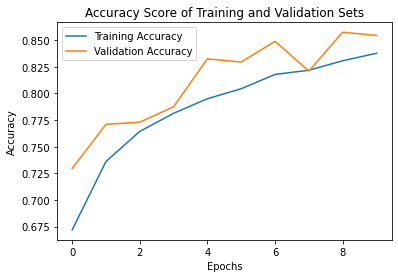

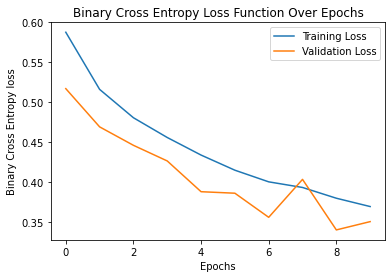

In [24]:
plot_acc_vs_epochs(history4)
plot_loss_vs_epochs(history4)

There was a clear reduction in accuracy from 95% in Model 2 to 85% in Model 4, however, this is still very accurate. This is evidence that our initial estimate of the learning rate was good. It would be fairly labour intensive and ultimately futile to tune this additional hyperparameter in an effort to attain a similar accuracy to a less complex model. The presence of overfitting is low as the accuracy scores of the training and validation sets are close.

Given the accuracies and complexities of the models defined above, it has been determined that Model 3 is the model to continue on with. This is because it has lower complexity than any of the other models and it has a validation accuracy of about 95%

## Model Tuning

As has been explained, we informally tuned our model by changing the complexity (by altering the number of hidden layers) as well as changing the values of the hyperparameters of the CNN model. Each time a model is fit, a large amount of computation if required. Therefore, it is not feasible to tuned the model with a large number of possible hyperparameter values. More tact will be required in the tuning of the model. We can see from the plots associated with Model 3 that the accuracy scores and the loss function level off at {}{}{}{}----------- epochs. Thus, one further model will be defined - Model 5 - whereby the number of epochs used will be {}{}{}{}----------. The should reduce complexity while keeping accuracy relatively constant.

In [ ]:
# fit model


In [ ]:
# plot

Commentary

## Model Assessment

